In [136]:
from sklearn.cluster import  MiniBatchKMeans, KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import math
from pylab import *
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
from geojson import Polygon
%matplotlib inline 

In [2]:
import folium
import json
from IPython.display import HTML

In [3]:
from logistics_functions import *

In [4]:
building_SF = pd.read_csv('..\shapefiles\\building_block_people_WGS_2.csv')

In [5]:
building_SF['num_people_int']=building_SF.num_people.round()

In [6]:
building_SF_array=np.array(building_SF)

In [7]:
building_virtual_buildings=[]
for row in building_SF_array:
    for i in range(int(row[-1])):
        building_virtual_buildings.append(row)
        

In [8]:
columns=['gid', 'fid_buildi', 'objname', 'numfaces', 'num_floor',
       'fid_landus', 'blklot', 'block_num', 'lot_num', 'resunits',
       'landuse', 'bldgsqft', 'yrbuilt', 'area_m2', 'county',
       'fid_tabblo', 'tractce10', 'housing10', 'lat', 'lon',
       'num_people', 'pop10', 'lat_lat', 'lon_lon', 'num_people_int']
building_virtual_buildings_df=pd.DataFrame(building_virtual_buildings, columns=columns)

In [9]:
building_SF_points=building_virtual_buildings_df[['lat_lat','lon_lon']]
data_plot=np.asarray(building_SF_points[:])

In [10]:
n = 5
k_means = KMeans(init='k-means++', n_clusters=n)
k_means.fit(building_SF_points)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
ft = (k_means_labels, k_means_cluster_centers)

C:\Users\Olga\Anaconda2\lib\site-packages\matplotlib\lines.py:1107: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


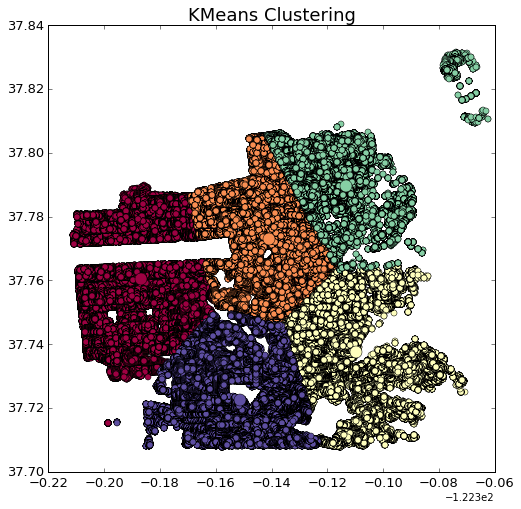

In [12]:
fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(data_plot[my_members, 1], data_plot[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [458]:
size_all= []
hull_all =[]
patches =[]
all_geom = {}
colors = plt.cm.hot(np.linspace(0, 1, n))
colors=colors.tolist()
#colors = ['yellow', 'red', 'blue', 'green', 'violet']
for i in range (k_means_labels.max()+1):
    my_members = k_means_labels==i
    unique = find_unique(building_virtual_buildings_df[my_members],'gid')
    size_all.append(unique)
    
    lat_lon = size_all[i][['lat_lat', 'lon_lon']]
    lat_lon_array = np.array(lat_lon)
    hull = ConvexHull(lat_lon_array)
    lat_lon_array = np.array(size_all[i][['lat_lat', 'lon_lon']])
    polygon_coords=[]
    for simplex in hull.vertices:
        x= lat_lon_array[simplex, 1]
        y = lat_lon_array[simplex, 0]
        coords = (x,y)
        polygon_coords.append(coords)
    polygon_coords_array = [polygon_coords]
    polygon = Polygon(polygon_coords_array)
    patches.append(polygon)


In [465]:
ice_map = folium.Map(location=[37.6236, -122.3750])
from random import randint
from matplotlib.colors import rgb2hex

i=0
for item in patches:
    with open('rest_%s.json' %i, 'w') as outfile: 
        json.dump(item, outfile)
    i=i+1
for z in range(i):
    color = matplotlib.colors.rgb2hex(colors[z])
    ice_map.geo_json(geo_path='rest_%s.json' %z, fill_color=color)
#ice_map.create_map(path='ice_map_test_2.html')
for item in k_means_cluster_centers:
    folium.RegularPolygonMarker(
    item,
    popup='Hawthorne Bridge',
    fill_color='#DC143C',
    number_of_sides=4,
    radius=7
    ).add_to(ice_map)
    
folium.RegularPolygonMarker(
cluster_center,
popup='Hawthorne Bridge',
fill_color='#00FFFF',
number_of_sides=6,
radius=10
).add_to(ice_map)

ice_map

In [437]:
cluster_center_meters = []
for item in k_means_cluster_centers:
    meters = merc(item[0], item[1])
    cluster_center_meters.append(meters)

In [ ]:
size_all_distance=[]
cluster_center_meters = [[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        meters = merc(row['lat_lat'], row['lon_lon'])
        cluster_center_meters[i].append(meters)
    total_distance_schedule = total_distance(optimized_travelling_salesman(cluster_center_meters[i]))
    total_peop = size_all[i]['num_people_int'].sum()
    totals = (i, total_peop, total_distance_schedule)
    size_all_distance.append(totals)

In [ ]:
totals_all_df = pd.DataFrame(size_all_distance, columns=['cluster', 'num_people', 'total_dist_m'])

In [ ]:
totals_all_df

In [ ]:
total_distance(optimized_travelling_salesman(cluster_center_meters))

In [ ]:
size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        harv=haversine(row['lat'],row['lon'], k_means_cluster_centers[i][0], k_means_cluster_centers[i][1])
        row['eu_dist'] = harv
        size_all_distance[i].append(row)

size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        point_lat_lon = [[row['lat'], row['lon']]]
        cluster_lat_lon = [[k_means_cluster_centers[i][0], k_means_cluster_centers[i][1]]]
        eu = cdist(point_lat_lon,cluster_lat_lon, 'euclidean')
        dist = eu[0][0]
        row['eu_dist'] = dist
        size_all_distance[i].append(row)

In [ ]:
n2 = 1
k_means_2 = KMeans(init='k-means++', n_clusters=n2)
k_means_2.fit(k_means_cluster_centers)

k_means_labels_2 = k_means_2.labels_
k_means_cluster_centers_2 = k_means_2.cluster_centers_
k_means_labels_unique_2 = np.unique(k_means_labels_2)
ft = (k_means_labels_2, k_means_cluster_centers_2)

fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n2))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n2), colors):
    my_members = k_means_labels_2 == k
    cluster_center = k_means_cluster_centers_2[k]
    plt.plot(k_means_cluster_centers[my_members, 1], k_means_cluster_centers[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [218]:
map_osm = folium.Map(location=[37.6236, -122.3750])
for item in k_means_cluster_centers:
    folium.RegularPolygonMarker(
    item,
    popup='Hawthorne Bridge',
    fill_color='#DC143C',
    number_of_sides=4,
    radius=7
    ).add_to(map_osm)
folium.RegularPolygonMarker(
cluster_center,
popup='Hawthorne Bridge',
fill_color='#00FFFF',
number_of_sides=6,
radius=10
).add_to(map_osm)

map_osm

In [ ]:
total_dist_all=[]
for i in range (k_means_labels.max()):
    df = pd.DataFrame(size_all_distance[i])
    total_dist = df['eu_dist'].sum()
    total_peop = df['num_people_int'].sum()
    all_totals = (i, total_peop, total_dist)
    total_dist_all.append(all_totals)

In [ ]:
totals_all_df = pd.DataFrame(total_dist_all, columns=['cluster', 'num_people', 'total_dist_m'])

In [ ]:
totals_all_df.to_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\shapefiles\\totals_all_df_%d.csv' % n)

In [ ]:
cluster_center_meters = []
for item in k_means_cluster_centers:
    meters = merc(item[0], item[1])
    cluster_center_meters.append(meters)

In [ ]:
total_distance(optimized_travelling_salesman(cluster_center_meters))